In [18]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# download dataset from GCP to keras if not yet downloaded

cache_path = pathlib.Path("../root/.keras/datasets/data")
if not cache_path.is_dir():
  dataset_url = "https://storage.googleapis.com/derma-data/raw_data/archive.zip"
  data_dir = tf.keras.utils.get_file(
                                    origin=dataset_url,
                                      extract=True,
                                      archive_format	='zip')
  data_dir = pathlib.Path(data_dir)

9766127229/9766127229 [==============================] - 274s 0us/step


In [3]:
batch_size = 32
img_height = 150
img_width = 150

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory('../root/.keras/datasets/data/train'
                                        ,batch_size=batch_size
                                        ,label_mode='categorical'
                                        ,image_size=(img_height,img_width))

Found 20179 files belonging to 8 classes.


In [5]:
class_names = train_ds.class_names

In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory('../root/.keras/datasets/data/test'
                                        ,batch_size=batch_size
                                        ,label_mode='categorical'
                                        ,image_size=(img_height,img_width))

Found 2606 files belonging to 8 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory('../root/.keras/datasets/data/valid'
                                        ,batch_size=batch_size
                                        ,label_mode='categorical'
                                        ,image_size=(img_height,img_width))

Found 2546 files belonging to 8 classes.


In [ ]:
# # Configurer l'ensemble de données pour les performances
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for x, y in train_ds.take(1):
  print(x.shape)

(32, 150, 150, 3)


In [ ]:
# Standardiser les données
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [9]:
# Load model
from keras.applications.densenet import DenseNet121

model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(150, 150, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(8,activation='softmax')(x) #FC-layer

29084464/29084464 [==============================] - 0s 0us/step


In [10]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [11]:
# freeze all layers except for the last 8
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [15]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [16]:
from tensorflow import keras
from keras.applications.densenet import preprocess_input

def new_preproc(X,y):
  return preprocess_input(X),y

train_preproc_ds = train_ds.map(new_preproc)
val_preproc_ds = val_ds.map(new_preproc)
test_preproc_ds = test_ds.map(new_preproc)

In [17]:
# Fit the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# es = EarlyStopping(monitor = 'val_accuracy', 
#                    mode = 'max', 
#                    patience = 5, 
#                    verbose = 1, 
#                    restore_best_weights = True)

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

#datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

history = model.fit(train_preproc_ds, 
                    validation_data=val_preproc_ds,
                    epochs=65,
                    batch_size=batch_size,
                    callbacks=[anne, checkpoint]
                    )

Epoch 1/65
631/631 [==============================] - ETA: 0s - loss: 1.2612 - accuracy: 0.5916 - recall: 0.5113
Epoch 1: val_loss improved from inf to 0.91326, saving model to model.h5
631/631 [==============================] - 215s 329ms/step - loss: 1.2612 - accuracy: 0.5916 - recall: 0.5113 - val_loss: 0.9133 - val_accuracy: 0.6614 - val_recall: 0.5534 - lr: 0.0010
Epoch 2/65
631/631 [==============================] - ETA: 0s - loss: 1.0061 - accuracy: 0.6357 - recall: 0.5372
Epoch 2: val_loss improved from 0.91326 to 0.87775, saving model to model.h5
631/631 [==============================] - 206s 326ms/step - loss: 1.0061 - accuracy: 0.6357 - recall: 0.5372 - val_loss: 0.8777 - val_accuracy: 0.6791 - val_recall: 0.5585 - lr: 0.0010
Epoch 3/65
631/631 [==============================] - ETA: 0s - loss: 0.9490 - accuracy: 0.6542 - recall: 0.5550
Epoch 3: val_loss improved from 0.87775 to 0.86083, saving model to model.h5
631/631 [==============================] - 200s 316ms/step - l

In [25]:
model.save('my_best_model.keras')

In [20]:
# Plot the accuracy
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

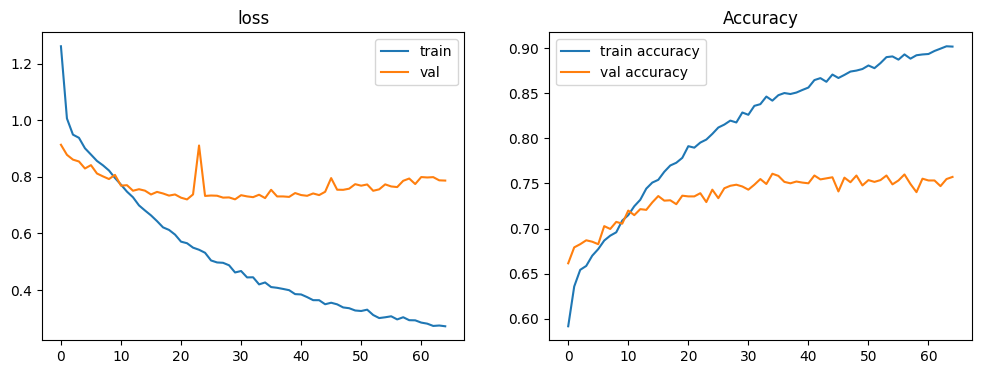

In [21]:
plot_history(history)

In [24]:
# Evaluate the model
res_vgg = model.evaluate(test_preproc_ds)

test_recall_vgg = res_vgg[-1]
test_accuracy_vgg = res_vgg[-2]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")
print(f"test_recall_vgg = {round(test_recall_vgg,2)*100} %")

82/82 [==============================] - 23s 274ms/step - loss: 0.8102 - accuracy: 0.7571 - recall: 0.7375
test_accuracy_vgg = 76.0 %
test_recall_vgg = 74.0 %


In [26]:
new_model = tf.keras.models.load_model('my_best_model.keras')

In [27]:
# Evaluate the restored model
new_model.evaluate(test_preproc_ds)

82/82 [==============================] - 26s 279ms/step - loss: 0.8102 - accuracy: 0.7571 - recall: 0.7375


[0.810234546661377, 0.7570989727973938, 0.7375288009643555]